# Predição de Câncer de Mama

In [17]:
# Import findspark 
import findspark

In [75]:
# Import Spark modules
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer, IndexToString

In [19]:
# Import Python modules
import time
import numpy as np
import pandas as pd
import seaborn as sns

In [20]:
# Import Sklearn Lib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import datasets

In [21]:
# Import Graphics modules
import matplotlib.pyplot as plt

# Show graphics inline
%matplotlib inline

In [22]:
# Build the Spark Session
spark = SparkSession.builder \
   .master("local[*]")\
   .appName("D-ACO/IDS") \
   .config('spark.sql.debug.maxToStringFields', 2000) \
   .config('spark.debug.maxToStringFields', 2000) \
   .getOrCreate()
   
sc = spark.sparkContext

23/05/20 22:59:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Seleção dos Dados

In [23]:
# Path to dataset file
data_path='../../datasets/'

In [37]:
# Load Breast Cancer CSV dataset to Spark Dataframe
df = spark.read.csv(data_path + "BreastCancerWisconsin.csv", 
                           sep=',',header='true', inferSchema=True)

In [67]:
df.dtypes

[('diagnosis', 'string'),
 ('radius_mean', 'double'),
 ('texture_mean', 'double'),
 ('perimeter_mean', 'double'),
 ('area_mean', 'double'),
 ('smoothness_mean', 'double'),
 ('compactness_mean', 'double'),
 ('concavity_mean', 'double'),
 ('concave points_mean', 'double'),
 ('symmetry_mean', 'double'),
 ('fractal_dimension_mean', 'double'),
 ('radius_se', 'double'),
 ('texture_se', 'double'),
 ('perimeter_se', 'double'),
 ('area_se', 'double'),
 ('smoothness_se', 'double'),
 ('compactness_se', 'double'),
 ('concavity_se', 'double'),
 ('concave points_se', 'double'),
 ('symmetry_se', 'double'),
 ('fractal_dimension_se', 'double'),
 ('radius_worst', 'double'),
 ('texture_worst', 'double'),
 ('perimeter_worst', 'double'),
 ('area_worst', 'double'),
 ('smoothness_worst', 'double'),
 ('compactness_worst', 'double'),
 ('concavity_worst', 'double'),
 ('concave points_worst', 'double'),
 ('symmetry_worst', 'double'),
 ('fractal_dimension_worst', 'double')]

In [68]:
df.printSchema()

root
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_worst: double (nullable = true)


In [54]:
#df.select("id","diagnosis","radius_mean").show();

In [55]:
#df = df.drop('_c32')
df = df.drop(*('id', '_c32'))

In [56]:
df.show(2)

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [62]:
# Contar a frequência de cada valor na coluna "diagnosis"
frequencia = df.groupBy("diagnosis").count().toPandas()

In [60]:
# Exibir o resultado
frequencia.show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



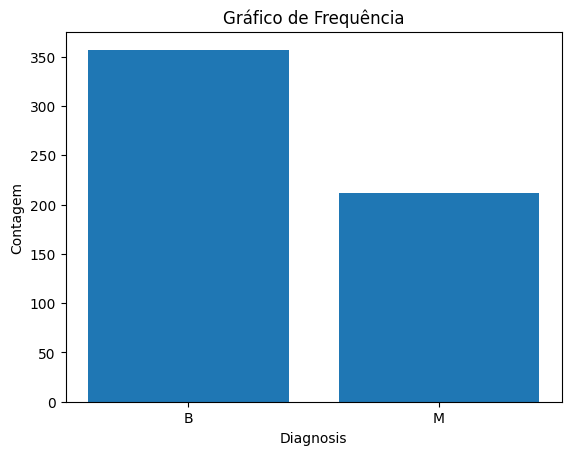

In [66]:
# Plotar o gráfico de barras
plt.bar(frequencia["diagnosis"], frequencia["count"])
plt.xlabel("Diagnosis")
plt.ylabel("Contagem")
plt.title("Gráfico de Frequência")
plt.show()

In [77]:
# ML libraries doesn't accept string column => everything should be numeric! 
# create a numeric column "label" based on string column "class" 

indexer = StringIndexer(inputCol="diagnosis", outputCol="label").fit(df)
label_data = indexer.transform(df)

In [78]:
# Save the inverse map from numeric "label" to string "class" to be used further in response
labelReverse = IndexToString().setInputCol("label")

# Show labeled dataframe with numeric lable
print("Dataframe with numeric lable")
label_data.show(5)

Dataframe with numeric lable
+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|label|
+---------+-----------+--

In [79]:
# Drop string column "class", no string column
label_data = label_data.drop("diagnosis")

# Most Machine Learning Lib inpute 2 columns: label (output) and feature (input)
# The label column is the result to train ML algorithm 
# The feature column should join all parameters as a Vector

# Set the column names that is not part of features list
ignore = ['label']
# list will be all columns parts of features
list = [x for x in label_data.columns if x not in ignore]

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
data = (assembler.transform(label_data).select("label","features"))

print("Final Dataframe suitable to classifier input format")
#data.printSchema()
data.show(5)

Final Dataframe suitable to classifier input format
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[17.99,10.38,122....|
|  1.0|[20.57,17.77,132....|
|  1.0|[19.69,21.25,130....|
|  1.0|[11.42,20.38,77.5...|
|  1.0|[20.29,14.34,135....|
+-----+--------------------+
only showing top 5 rows



In [82]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [86]:
#matrix.collect()[0]["pearson({})".format(vector_col)].values

In [90]:
matrix = Correlation.corr(df_vector, 'corr_vector').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_variables, index=numeric_variables) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `corr_vector` cannot be resolved. Did you mean one of the following? [`corr_features`].;
'Project ['corr_vector]
+- Project [corr_features#2074]
   +- Project [label#1688, features#1916, UDF(struct(label, label#1688, features, features#1916)) AS corr_features#2074]
      +- Project [label#1688, features#1916]
         +- Project [radius_mean#795, texture_mean#796, perimeter_mean#797, area_mean#798, smoothness_mean#799, compactness_mean#800, concavity_mean#801, concave points_mean#802, symmetry_mean#803, fractal_dimension_mean#804, radius_se#805, texture_se#806, perimeter_se#807, area_se#808, smoothness_se#809, compactness_se#810, concavity_se#811, concave points_se#812, symmetry_se#813, fractal_dimension_se#814, radius_worst#815, texture_worst#816, perimeter_worst#817, area_worst#818, smoothness_worst#819, compactness_worst#820, concavity_worst#821, concave points_worst#822, symmetry_worst#823, fractal_dimension_worst#824, label#1688, UDF(struct(radius_mean, radius_mean#795, texture_mean, texture_mean#796, perimeter_mean, perimeter_mean#797, area_mean, area_mean#798, smoothness_mean, smoothness_mean#799, compactness_mean, compactness_mean#800, concavity_mean, concavity_mean#801, concave points_mean, concave points_mean#802, symmetry_mean, symmetry_mean#803, fractal_dimension_mean, fractal_dimension_mean#804, radius_se, radius_se#805, texture_se, texture_se#806, perimeter_se, perimeter_se#807, area_se, area_se#808, smoothness_se, smoothness_se#809, compactness_se, compactness_se#810, concavity_se, concavity_se#811, concave points_se, concave points_se#812, symmetry_se, symmetry_se#813, fractal_dimension_se, fractal_dimension_se#814, radius_worst, radius_worst#815, texture_worst, texture_worst#816, perimeter_worst, perimeter_worst#817, area_worst, area_worst#818, smoothness_worst, smoothness_worst#819, compactness_worst, compactness_worst#820, concavity_worst, concavity_worst#821, concave points_worst, concave points_worst#822, symmetry_worst, symmetry_worst#823, fractal_dimension_worst, fractal_dimension_worst#824)) AS features#1916]
            +- Project [radius_mean#795, texture_mean#796, perimeter_mean#797, area_mean#798, smoothness_mean#799, compactness_mean#800, concavity_mean#801, concave points_mean#802, symmetry_mean#803, fractal_dimension_mean#804, radius_se#805, texture_se#806, perimeter_se#807, area_se#808, smoothness_se#809, compactness_se#810, concavity_se#811, concave points_se#812, symmetry_se#813, fractal_dimension_se#814, radius_worst#815, texture_worst#816, perimeter_worst#817, area_worst#818, smoothness_worst#819, compactness_worst#820, concavity_worst#821, concave points_worst#822, symmetry_worst#823, fractal_dimension_worst#824, label#1688]
               +- Project [diagnosis#794, radius_mean#795, texture_mean#796, perimeter_mean#797, area_mean#798, smoothness_mean#799, compactness_mean#800, concavity_mean#801, concave points_mean#802, symmetry_mean#803, fractal_dimension_mean#804, radius_se#805, texture_se#806, perimeter_se#807, area_se#808, smoothness_se#809, compactness_se#810, concavity_se#811, concave points_se#812, symmetry_se#813, fractal_dimension_se#814, radius_worst#815, texture_worst#816, perimeter_worst#817, area_worst#818, smoothness_worst#819, compactness_worst#820, concavity_worst#821, concave points_worst#822, symmetry_worst#823, fractal_dimension_worst#824, UDF(cast(diagnosis#794 as string)) AS label#1688]
                  +- Project [diagnosis#794, radius_mean#795, texture_mean#796, perimeter_mean#797, area_mean#798, smoothness_mean#799, compactness_mean#800, concavity_mean#801, concave points_mean#802, symmetry_mean#803, fractal_dimension_mean#804, radius_se#805, texture_se#806, perimeter_se#807, area_se#808, smoothness_se#809, compactness_se#810, concavity_se#811, concave points_se#812, symmetry_se#813, fractal_dimension_se#814, radius_worst#815, texture_worst#816, perimeter_worst#817, area_worst#818, smoothness_worst#819, compactness_worst#820, concavity_worst#821, concave points_worst#822, symmetry_worst#823, fractal_dimension_worst#824]
                     +- Project [id#793, diagnosis#794, radius_mean#795, texture_mean#796, perimeter_mean#797, area_mean#798, smoothness_mean#799, compactness_mean#800, concavity_mean#801, concave points_mean#802, symmetry_mean#803, fractal_dimension_mean#804, radius_se#805, texture_se#806, perimeter_se#807, area_se#808, smoothness_se#809, compactness_se#810, concavity_se#811, concave points_se#812, symmetry_se#813, fractal_dimension_se#814, radius_worst#815, texture_worst#816, perimeter_worst#817, area_worst#818, smoothness_worst#819, compactness_worst#820, concavity_worst#821, concave points_worst#822, symmetry_worst#823, fractal_dimension_worst#824]
                        +- Relation [id#793,diagnosis#794,radius_mean#795,texture_mean#796,perimeter_mean#797,area_mean#798,smoothness_mean#799,compactness_mean#800,concavity_mean#801,concave points_mean#802,symmetry_mean#803,fractal_dimension_mean#804,radius_se#805,texture_se#806,perimeter_se#807,area_se#808,smoothness_se#809,compactness_se#810,concavity_se#811,concave points_se#812,symmetry_se#813,fractal_dimension_se#814,radius_worst#815,texture_worst#816,perimeter_worst#817,area_worst#818,smoothness_worst#819,compactness_worst#820,concavity_worst#821,concave points_worst#822,symmetry_worst#823,fractal_dimension_worst#824,_c32#825] csv


In [84]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

NameError: name 'corr_matrix_df' is not defined

<Figure size 1600x500 with 0 Axes>

In [87]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

In [88]:
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

In [89]:

import numpy as np
import plotly.graph_objects as go

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray()

# to only show one triangle
m = matrix
m[np.triu_indices(m.shape[0], 0)] = None

corr_matrix = m.tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_columns, index=numeric_columns) 


labels = corr_matrix_df.columns.values
fig = go.Figure(data=go.Heatmap(
                    z=corr_matrix_df,
                    x = labels,
                    y = labels, 
                    text=corr_matrix_df.round(2),
                    texttemplate="%{text}",
                    textfont={"size":8},
                    colorscale='greens'
                    )
                )
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(autorange="reversed")

fig.show()

NameError: name 'numeric_columns' is not defined

In [ ]:
# Stop Spark
spark.stop()